*Теоретический материал:* https://youtu.be/twRYNROm7Jg?t=2170

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=3399

In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


#Автокодировщик

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=3446

In [ ]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(10, 4)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([0, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

1.0


## MINIST

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=4485

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test

xTrainMnist = xTrainMnist.astype('float32')/255 # представляем в виде значений от 0 до 1

xTrainMnist = xTrainMnist.reshape(xTrainMnist.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам

In [ ]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаем автокодировщик
modelAutoMnist.fit(xTrainMnist[:10000], xTrainMnist[:10000], epochs=50, batch_size=256, validation_data = (xTrainMnist[10000:12000], xTrainMnist[10000:12000]))

Epoch 1/50
40/40 [==============================] - 4s 107ms/step - loss: 0.1800 - val_loss: 0.1890
Epoch 2/50
40/40 [==============================] - 4s 88ms/step - loss: 0.0890 - val_loss: 0.1352
Epoch 3/50
40/40 [==============================] - 4s 88ms/step - loss: 0.0577 - val_loss: 0.1113
Epoch 4/50
40/40 [==============================] - 3s 87ms/step - loss: 0.0420 - val_loss: 0.1041
Epoch 5/50
40/40 [==============================] - 3s 87ms/step - loss: 0.0323 - val_loss: 0.1021
Epoch 6/50
40/40 [==============================] - 4s 88ms/step - loss: 0.0257 - val_loss: 0.1008
Epoch 7/50
40/40 [==============================] - 3s 87ms/step - loss: 0.0211 - val_loss: 0.0974
Epoch 8/50
40/40 [==============================] - 4s 88ms/step - loss: 0.0178 - val_loss: 0.0856
Epoch 9/50
40/40 [==============================] - 4s 88ms/step - loss: 0.0154 - val_loss: 0.0632
Epoch 10/50
40/40 [==============================] - 3s 87ms/step - loss: 0.0135 - val_loss: 0.0433
Epoch 11

In [ ]:
#modelAutoMnist.save_weights('modelAutoMnist.h5') # Сохраняем модель
modelAutoMnist.load_weights('modelAutoMnist.h5') # Сохраняем модель

In [ ]:
modelAutoMnist.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

In [ ]:
predMnist = modelAutoMnist.predict(xTrainMnist[:12000]) # просим модель вернуть нам изображение по первым 12тыс. xTrainMnist

predMnist = predMnist * 255 # представляем в виде значений от 0 до 255
predMnist = predMnist.astype('uint8') # устанавливаем 8битовый тип

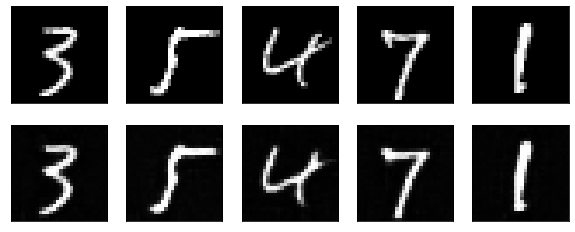

In [ ]:
plotImages(xTrainMnist, predMnist, shape=(28,28)) # покажем исходные и восстановленные картинки

In [ ]:
err = [getMSE(xTrainMnist[i], predMnist[i] / 255) for i in range(len(predMnist))]# Возьмем среднеквадратичную ошибку от правильной картинки, и восстановленной, пройдя по 12тыс изображений
n = 10000
print("Средняя ошибка на MNIST:", sum(err[0:n]) / n) # взглянем на среднюю ошибку на обучающей выборке
print("Средняя шибка на  тестовом наборе MNIST:", sum(err[10000:10000+n]) / n) # и на проверочной выборке

Средняя ошибка на MNIST: 0.0027681748358120506
Средняя шибка на  тестовом наборе MNIST: 0.0005630607164015028


### Fashion_mnist

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=4685

In [ ]:
# Загрузим данные из fashion_mnist - базы с одеждой,обувью и т.п
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()

xTrainMnistF = xTrainMnistF.astype('float32')/255 # представляем в виде значений от 0 до 1

xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам

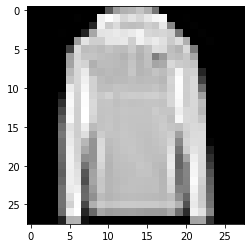

In [ ]:
# Взглянем на пример изображения из базы fashion_mnist
n = 24 # выбираем картинку
xxT = xTrainMnistF[n].reshape((28,28)) # указываем размеры этой картинки как 28*28
xxT = xxT * 255 # представляем в виде значений от 0 до 255

img = Image.fromarray(xxT) # из указанного массива значений будем строить рисунок
plt.imshow(img.convert('RGBA')) # переводим в 4х-канальное цветовое пространство RGBA
plt.show() # покажем картинку

In [ ]:
predMnistF = modelAutoMnist.predict(xTrainMnistF[:100]) # сделаем предикт для первых ста картинок из fashion_mnist

predMnistF = predMnistF * 255 # представляем в виде значений от 0 до 255
predMnistF = predMnistF.astype('uint8') # устанавливаем 8битовый тип

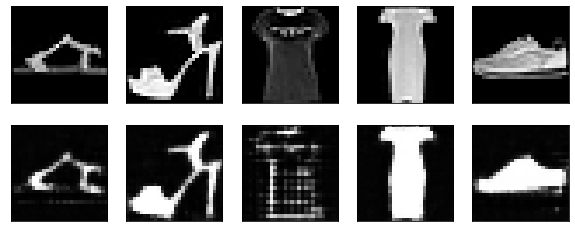

In [ ]:
plotImages(xTrainMnistF, predMnistF, shape=(28,28)) # выведем на экран картинки правильных и восстановленных изображений 

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для Mnist и для базы с одеждой 
errF = [getMSE(xTrainMnistF[i], predMnistF[i] / 255) for i in range(len(predMnistF))]
print("Ошибка на Mnist:", err[10000:10020])
print("Ошибка на одежде:", errF[:20])
print("Средняя ошибка на Mnist:", round(sum(err[10000:]) / len(err[10000:]), 4))
print("Средняя ошибка на одежде:", round(sum(errF) / len(errF), 4))
print("Максимальная ошибка на Mnist:", round(max(err[10000:]),4))
print("Минимальная ошибка на одежде:", round(min(errF),4))

Ошибка на Mnist: [0.0025595726500559227, 0.0038332979503750753, 0.0020696904699892887, 0.0038468327140802863, 0.002413278977044254, 0.004955472149062354, 0.0011825906657779326, 0.0010904361093434217, 0.007141346684913759, 0.002477716504799114, 0.0035004000829901593, 0.0028472171915188233, 0.003933416415962047, 0.0024413881294321864, 0.004748919085876231, 0.004525280576586769, 0.0029350757910314934, 0.0022236540050294654, 0.002634700886048097, 0.0014733147457120204]
Ошибка на одежде: [0.02392500007697732, 0.02507445998747572, 0.03644959943605095, 0.06267387080476346, 0.01280578843336727, 0.056138883888861076, 0.011842442623452552, 0.013096983180403378, 0.017122123416343275, 0.008921352674888984, 0.05086636115134964, 0.01251125881169633, 0.026487359883618892, 0.018791222527045407, 0.014279810330984197, 0.01628292371990035, 0.03329400242516893, 0.03151511310069467, 0.08249830526770005, 0.05554290336260151]
Средняя ошибка на Mnist: 0.0028
Средняя ошибка на одежде: 0.0326
Максимальная ошибк

In [ ]:
bias = 0.01 # установим какое-то пороговое значение

isMnist = [e < bias for e in err[10000:]] # запишем каждую ошибку больше порогового значения, Mnist
isMnistF = [e < bias for e in errF] # запишем каждую ошибку больше порогового значения, fashion_mnist

print("Mnist распознано, как Mnist: ", round(100*sum(isMnist) / len(isMnist)),"%", sep="")
print("Одежды распознано, как Mnist: ", round(100*sum(isMnistF) / len(isMnistF)),"%", sep="")
print("Суммарная ошибка: ", round(100*(1-(sum(isMnist) / len(isMnist)) + sum(isMnistF) / len(isMnistF))),"%", sep="")

Mnist распознано, как Mnist: 100.0%
Одежды распознано, как Mnist: 11.0%
Суммарная ошибка: 11.0%


##Лица

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=4981

In [ ]:
!unzip -q '/content/drive/My Drive/Базы/Лица.zip' # распоковываем базу с лицами с google диска в colaboratory

In [ ]:
images_dir = 'Лица' # зададим имя папки в которую распоковали изображения
img_height = 112 # зададим высоту изображений
img_width = 80 # зададим ширину избражений

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
cur_time = time.time() 
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения лиц
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 37.76с


In [ ]:
xTrain_img = xTrain_imag/255 # отнормируем изображения от 0 до 1

In [ ]:
xTrain_img.shape # выведем размерность массива

(5018, 224, 160, 1)

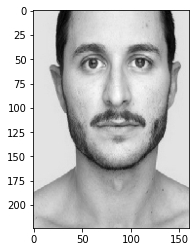

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') #выведем случайное изображение
plt.show()

In [ ]:
modelAutoFase = baseAutoencoder() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoFase.fit(xTrain_img[:4700], xTrain_img[:4700], epochs=150, batch_size=100, validation_data = (xTrain_img[4700:], xTrain_img[4700:]))

In [ ]:
#modelAutoFase.save_weights('modelAutoFase.h5') # Сохраняем модель
modelAutoFase.load_weights('modelAutoFase.h5') # Сохраняем модель

In [ ]:
predFase = modelAutoFase.predict(xTrain_img[:100]) # сделаем предикт для первых ста картинок лиц

predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

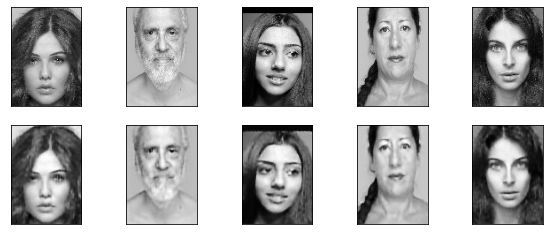

In [ ]:
plotImages(xTrain_img, predFase) #выведем оригинальные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFase = [getMSE(xTrain_img[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Лицах:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFase),4)) #найдем минимальную ошибку

Ошибка на Лицах: [0.004599949813297899, 0.0009035192327270322, 0.0008061324927065707, 0.0014918474653399791, 0.0009679588473509244, 0.0005282756132048666, 0.0008753434932406358, 0.0027719251228642224, 0.003333429682951779, 0.0005804000883903837, 0.001981234951601264, 0.000981611052185858, 0.00036560280486907485, 0.0004407096098068666, 0.0011694920167995716, 0.0007644828895760703, 0.000755956114432159, 0.0031142281990923417, 0.0007784524515944804, 0.000705769205750293]
Средняя ошибка на Лицах: 0.0014
Минимальная ошибка на Лицах: 0.0004


In [ ]:
bias = 0.005 # установим какое-то пороговое значение

isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения

print("Лица распознаны, как Лица: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Лица распознаны, как Лица: 100.0%


#Генерация из шума

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=5280

In [ ]:
noise = np.random.sample((100,112,80,1)) # создаем 100 картинок шума
print(noise.shape) # выведем размеры

(100, 112, 80, 1)


In [ ]:
predNoise = modelAutoFase.predict(noise[:100]) # сделаем предикт этих шумовых картинок

predNoise = predNoise * 255 # представляем в виде значений от 0 до 255
predNoise = predNoise.astype('uint8') # устанавливаем 8битовый тип

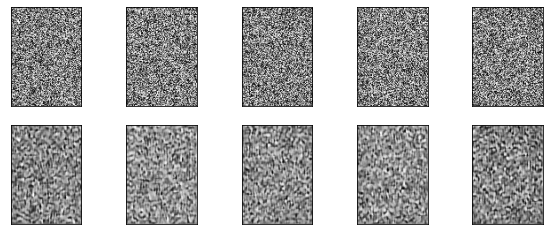

In [ ]:
plotImages(noise, predNoise) # выведем на экран исходные шумовые картинки и восстановленые 

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для Mnist и для шумовых изображений
errN = [getMSE(noise[i], predNoise[i] / 255) for i in range(len(predFase))]
print("Ошибка на Лицах:", errFase[0:20])
print("Ошибка на шуме:", errN[0:20])
print("Средняя ошибка на Лицах:", round(sum(errFase) / len(errFase), 4))
print("Средняя ошибка на шуме:", round(sum(errN) / len(errN), 4))
print("Максимальная ошибка на Лицах:", round(max(errFase),4))
print("Минимальная ошибка на шуме:", round(min(errN),4))

Ошибка на Лицах: [0.002009014456346982, 0.0018291266135435874, 0.0007658507432475776, 0.000895642978857282, 0.0006044895726923848, 0.0008172509111688766, 0.0009884403527551846, 0.0007990576024808877, 0.0011070416956677227, 0.001174759517832789, 0.000891932247424316, 0.0020743636763534616, 0.0011990343064650984, 0.0005905733065923729, 0.0009970515768200651, 0.0009529372479598698, 0.0005252666703872035, 0.0017861727096064074, 0.0011111148384153535, 0.001127380755156293]
Ошибка на шуме: [0.06780270666016273, 0.06728622674751113, 0.06698465903105065, 0.06680297308314345, 0.06554733396564563, 0.06689093622894042, 0.06564524447629717, 0.06623669593517383, 0.06593948600952816, 0.0660353928654221, 0.0659790653591386, 0.06612412479500702, 0.06680312330945105, 0.06663726690525255, 0.06725916906045516, 0.06620390521429202, 0.06639663701964271, 0.066449743800742, 0.06550153363850414, 0.06584877239276458]
Средняя ошибка на Лицах: 0.0013
Средняя ошибка на шуме: 0.0664
Максимальная ошибка на Лицах: 0

#Удаление шума

In [ ]:
def addNoise(x, noiseVal): # объявим функцию добавления шума
  #noise = np.random.sample((x.shape[0],28,28,1))
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

In [ ]:
noisedXTrainFase = addNoise(xTrain_img, 0.4) # cоздаем зашумленный вариант лиц из xTrain_img

In [ ]:
plotImages(xTrain_img, noisedXTrainFase) # выведем на экран исходные лица и зашумленные варианты 

In [ ]:
def denoiseAutoencoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((112,80,1)) # задаём входные размеры

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 7*5*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(7*5*256, activation='relu')(z) # и еще полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
    x = Reshape((7,5,256))(x) # меняем размеры - картинка 7*5 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 7*5 до 14*10
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 14*10 до 28*20
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 28*20 до 56*40
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 56*40 до 112*80
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

In [ ]:
modelDenoiseFase = denoiseAutoencoder()
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
modelDenoiseFase.fit(noisedXTrainFase[:4700], xTrain_img[:4700], epochs=80, batch_size=100, validation_data = (noisedXTrainFase[4700:], xTrain_img[4700:]))

Epoch 1/80
47/47 [==============================] - 16s 338ms/step - loss: 0.0462 - val_loss: 0.0693
Epoch 2/80
47/47 [==============================] - 15s 323ms/step - loss: 0.0134 - val_loss: 0.0679
Epoch 3/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0086 - val_loss: 0.0652
Epoch 4/80
47/47 [==============================] - 15s 324ms/step - loss: 0.0071 - val_loss: 0.0606
Epoch 5/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0064 - val_loss: 0.0531
Epoch 6/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0060 - val_loss: 0.0425
Epoch 7/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0057 - val_loss: 0.0307
Epoch 8/80
47/47 [==============================] - 15s 324ms/step - loss: 0.0054 - val_loss: 0.0207
Epoch 9/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0053 - val_loss: 0.0148
Epoch 10/80
47/47 [==============================] - 15s 325ms/step - loss: 0.0051 - val_lo

In [ ]:
modelDenoiseFase.save_weights('modelDenoiseFase.h5') # Сохраняем модель
#modelDenoiseFase.load_weights('modelDenoiseFase.h5') # Сохраняем модель

In [ ]:
predFaseDenoise = modelDenoiseFase.predict(noisedXTrainFase[:4000]) # подаем 4тыс зашумленных картинок и делаем предикт

predFaseDenoise = predFaseDenoise * 255 # представляем в виде значений от 0 до 255
predFaseDenoise = predFaseDenoise.astype('uint8') # устанавливаем 8битовый тип

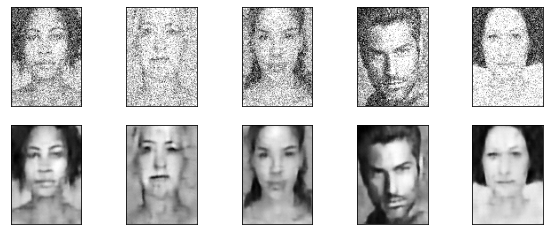

In [ ]:
plotImages(noisedXTrainFase, predFaseDenoise) # взглянем как отрабатывает шумоподавление на зашумленных картинках

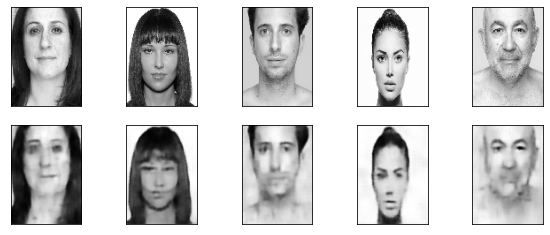

In [ ]:
plotImages(xTrain_img, predFaseDenoise) # взглянем как отрабатывает шумоподавление на лицах

#Определение мошеннических операций

*Разбор данного раздела:* https://youtu.be/twRYNROm7Jg?t=5858

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Базы/creditcard.csv") # читаем базу

In [ ]:
df.head() # выводим первые пять строк

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Удаляем столбец со временем
data = df.drop(['Time'], axis=1)
# Нормализуем столбец с суммой транзакции
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

frauds = data[data.Class == 1] # записываем мошеннические операции
normal = data[data.Class == 0] # записываем нормальные операции

In [ ]:
frauds.shape # смотрим какие размеры у мошеннических операций

(492, 30)

In [ ]:
normal.shape # смотрим какие размеры у нормальных операций

(284315, 30)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём нормальные операции и разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Удаляем класс в обучающем наборе данных
X_train = X_train.drop(['Class'], axis=1)
# Добавляем все мошеннические транзакции в тестовый набор данных
X_test = pd.concat([X_test, frauds])
# Делаем метки для тестового набора данных
y_test = X_test['Class']
# Удаляем класс у тестового набора данных
X_test = X_test.drop(['Class'], axis=1)
# Преобразуем данные в массивы numpy
X_train = X_train.values
X_test = X_test.values

In [ ]:
print(X_train.shape) # взглянем на размеры обучающих данных

(227452, 29)


In [ ]:
def creditcardAutoencoder(): # объявляем автокодировщик для определения мошенич.транзакций
  dataSize = X_train.shape[1] # берём размеры X_train по второй оси(30)
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='linear')(x) # и через полносвязный слой размером 30 
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer='Adam', loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = creditcardAutoencoder()
history = model.fit(X_train, X_train,
                    epochs=5,
                    batch_size=32) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0350
Epoch 2/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0199
Epoch 3/10
7108/7108 [==============================] - 13s 2ms/step - loss: 0.0164
Epoch 4/10
7108/7108 [==============================] - 13s 2ms/step - loss: 0.0113
Epoch 5/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0095
Epoch 6/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0077
Epoch 7/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0066
Epoch 8/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0051
Epoch 9/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0047
Epoch 10/10
7108/7108 [==============================] - 12s 2ms/step - loss: 0.0041


In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_normal = mse[y_test.values == 0] # среднеквадратичная ошибка на нормальных операциях
mse_frauds = mse[y_test.values == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print("Минимальная ошибка нормальных трансакций:", round(min(mse_normal),4)) #найдем минимальную среднеквадратичную ошибку на нормальных операциях
print("Максимальная ошибка нормальных трансакций:", round(max(mse_normal),4)) #найдем максимальную среднеквадратичную ошибку на нормальных операциях
print("Средняя ошибка нормальных трансакций:", round(sum(mse_normal) / len(mse_normal),4)) # среднюю ошибку

Минимальная ошибка нормальных трансакций: 0.0
Максимальная ошибка нормальных трансакций: 2.6496
Средняя ошибка нормальных трансакций: 0.0011


In [ ]:
print("Минимальная ошибка мошеннических трансакций:", round(min(mse_frauds),4)) #найдем минимальную среднеквадратичную ошибку на мошеннических операциях
print("Максимальная ошибка мошеннических трансакций:", round(max(mse_frauds),4)) #найдем максимальную среднеквадратичную ошибку на мошеннических операциях
print("Средняя ошибка мошеннических трансакций:", round(sum(mse_frauds) / len(mse_frauds),4)) # среднюю ошибку

Минимальная ошибка мошеннических трансакций: 0.0001
Максимальная ошибка мошеннических трансакций: 61.8625
Средняя ошибка мошеннических трансакций: 2.3047


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isNormal = mse_normal < bias # если ошибка меньше порога - то транзакция нормальная
  isFrauds = mse_frauds > bias # если ошибка больше порога - то транзакция мошенническая

  accNormal = sum(isNormal) / len(isNormal) # вычисляем процент нормальных операций
  accFaruds = sum(isFrauds) / len(isFrauds) # вычисляем процент мошеннических операций

  print("Распознано нормальных трансакций: ", round(100*accNormal), "%", sep="")
  print("Распознано мошеннических трансакций: ", round(100*accFaruds), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accNormal + accFaruds)), "%", sep="")

In [ ]:
getAccByBias(1.5) # выведем данные по распознаванию с конкретным пороговым значением

Распознано нормальных трансакций: 100.0%
Распознано мошеннических трансакций: 19.0%
Средняя точность распознавания: 59.0%
